In [1]:
#data format library
import h5py
#numpy
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
# %matplotlib notebook
from sklearn.cluster import KMeans

import sys
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as colors
import os
from scipy.integrate import odeint
#change path to where 'manuscript_data' is saved
dir_path = '/home/antonio/Repositories/manuscript_data/'
sys.path.append(dir_path+'/code/utils/')
import operator_calculations as op_calc
import worm_dynamics as worm_dyn
import stats

In [2]:
import scipy.io
mat = scipy.io.loadmat(dir_path+'Foraging/ForagingData/wormCentroid.mat')
X_worm,Y_worm = mat['cmX'],mat['cmY']

centroids_w = []
for kw in range(X_worm.shape[0]):
    centroids_w.append(np.vstack([X_worm[kw,::2],Y_worm[kw,::2]]).T)
    
all_centroids = ma.vstack(centroids_w)

In [3]:
mat=h5py.File(dir_path+'Foraging/ForagingData/PNAS2011-DataStitched.mat','r')

refs=list(mat['#refs#'].keys())[1:]
tseries_w=[ma.masked_invalid(np.array(mat['#refs#'][ref]).T)[:,:5] for ref in refs]
mat.close()
frameRate=16.
dt=1/frameRate

masked_ts_w = []
for worm in np.arange(len(tseries_w)):
    ts_w = tseries_w[worm]
    ts_w[0] = ma.masked
    ts_w[-1] = ma.masked
    masked_ts_w.append(ts_w)

import worm_dynamics as worm_dyn
segments=op_calc.segment_maskedArray(ma.vstack(masked_ts_w),5)
omegas_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
a3s_all=ma.zeros(ma.vstack(masked_ts_w).shape[0])
for t0,tf in segments:
    phi,omega,a3=worm_dyn.compute_phi_omega_a3(ma.vstack(masked_ts_w),t0,tf)
    omegas_all[t0:tf] = omega
    a3s_all[t0:tf] = a3
omegas_all[omegas_all==0]=ma.masked
a3s_all[a3s_all==0]=ma.masked

In [4]:
eigenworms_matrix = np.loadtxt(dir_path+'Foraging/ForagingData/EigenWorms.csv', delimiter=',').astype(np.float32)
thetas_w = ma.array([ts.dot(eigenworms_matrix[:,:5].T) for ts in masked_ts_w])
thetas_all = ma.vstack(thetas_w)
curvature_all = ma.abs(thetas_all).mean(axis=1)

In [6]:
delay = int(0.75*frameRate)
wsize = 2*delay

omegas_average = []
thetas_average=[]
indices = []
for kt in range(0,len(omegas_all),wsize):
    if ma.count(omegas_all[kt:kt+wsize])>0:
        omegas_average.append(np.median(omegas_all[kt:kt+wsize].compressed()))
        thetas_average.append(np.median(curvature_all[kt:kt+wsize].compressed()))
        indices.append(int(kt+wsize/2))

In [5]:
n_clusters=1000
f = h5py.File(dir_path+'Foraging/symbol_sequences/labels_{}_clusters.h5'.format(n_clusters))
labels_traj = ma.array(f['labels_traj'],dtype=int)
mask_traj = np.array(f['mask_traj'],dtype=bool)
labels_phspace = ma.array(f['labels_phspace'],dtype=int)
mask_phspace = np.array(f['mask_phspace'],dtype=bool)
centers_phspace = np.array(f['centers_phspace'])
centers_traj = np.array(f['centers_traj'])
f.close()

labels_traj[mask_traj] = ma.masked
labels_phspace[mask_phspace] = ma.masked

In [6]:
f = h5py.File(dir_path+'Foraging/ForagingData/phspace_K_10_m_7.h5','r')
traj_matrix = ma.array(f['traj_matrix'])
phspace = ma.array(f['phspace'])
components = np.array(f['modes'])
f.close()

In [9]:
lcs,P = op_calc.transition_matrix(labels_traj,delay,return_connected=True)
inv_measure = op_calc.stationary_distribution(P)
final_labels = op_calc.get_connected_labels(labels_traj,lcs)
n_modes=10
R = op_calc.get_reversible_transition_matrix(P)
eigvals,eigvecs = op_calc.sorted_spectrum(R,k=n_modes)
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices][1:].real
eigvals[np.abs(eigvals-1)<1e-12] = np.nan
eigvals[eigvals<1e-12] = np.nan
t_imp =  -(delay*dt)/np.log(eigvals)
eigfunctions = eigvecs.real/np.linalg.norm(eigvecs.real,axis=0)
eigfunctions_traj = ma.array(eigfunctions)[final_labels,:]
eigfunctions_traj[final_labels.mask] = ma.masked

phi2 = eigfunctions[:,1]

In [10]:
c_range,rho_sets,idx,kmeans_labels = op_calc.optimal_partition(phi2,inv_measure,P,return_rho=True)

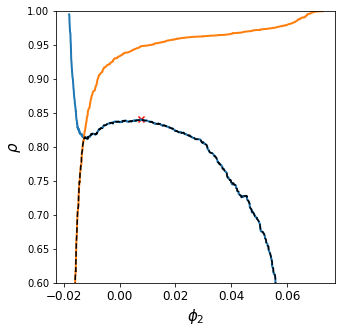

In [11]:
plt.figure(figsize=(5,5))
plt.plot(c_range,rho_sets,lw=2)
rho_c = np.min(rho_sets,axis=1)
plt.plot(c_range,rho_c,c='k',ls='--')
plt.scatter(c_range[idx],rho_c[idx],c='r',marker='x')
plt.ylim(.6,1)
# plt.xlim(-0.04,0.04)
plt.xlabel(r'$\phi_2$',fontsize=15)
plt.ylabel(r'$\rho$',fontsize=15)
plt.xticks(fontsize=12)
# plt.savefig('rho_2states_Foraging.pdf')
plt.show()

In [12]:
pi_states = np.array([inv_measure[kmeans_labels==state_idx].sum() for state_idx in np.arange(2)])

In [13]:
cluster_traj = ma.copy(final_labels)
cluster_traj[~final_labels.mask] = ma.array(kmeans_labels)[final_labels[~final_labels.mask]]
cluster_traj[final_labels.mask] = ma.masked

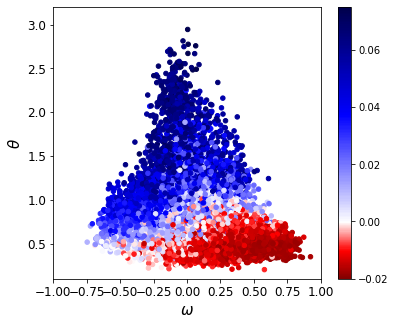

In [14]:
from matplotlib.colors import DivergingNorm,TwoSlopeNorm
vmin,vmax=-0.02,0.075

plt.figure(figsize=(6,5))
plt.scatter(omegas_average,thetas_average,norm=TwoSlopeNorm(0,vmin=vmin,vmax=vmax),c=eigfunctions_traj[indices,1],s=20,alpha=1,cmap='seismic_r')
plt.xlim(-1,1)
plt.ylim(.1,3.2)
plt.xlabel(r'$\omega$',fontsize=15)
plt.ylabel(r'$\theta$',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.colorbar()
# plt.savefig('omega_theta_phi_2_averaged_2_delay.pdf')
plt.show()

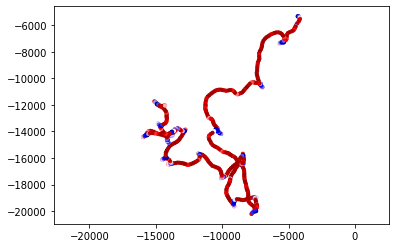

In [15]:
t0_w = 33600*10
t0,tf = t0_w+10000,t0_w+int(600*frameRate)+10000
t_samp=16
plt.figure()
plt.scatter(all_centroids[t0:tf,0][::t_samp],all_centroids[t0:tf,1][::t_samp],norm=TwoSlopeNorm(0,vmin=vmin,vmax=vmax),c=eigfunctions_traj[t0:tf,1][::t_samp],cmap='seismic_r',s=10,alpha=1)
plt.axis('equal')
# plt.savefig('example_10min_centroid_traj_phi2.pdf')
# plt.xlim(-20000,5000)
plt.show()

# Dwell time distributions

In [16]:
from lmfit import minimize, Parameters, Parameter, report_fit

def fit_tscales(x,y,b0=10,d0=50):
    
    def fcn2(params,x,data):
        a=params['a'].value
        b=params['b'].value
        c=params['c'].value
        d=params['d'].value
        #Fits the drift

        return (a*np.exp(-x/b) + c * np.exp(-x/d) - data)

    params = Parameters()
    params.add('a',   value= 1)
    params.add('b', value= b0,min=0)
    params.add('c', value= 1)
    params.add('d', value= d0,min=0)

    # do fit, here with leastsq model
    result = minimize(fcn2, params, args=(x,y))
    
    p1 = result.params['a'].value
    p2 = result.params['b'].value
    p3 = result.params['c'].value
    p4 = result.params['d'].value
    tscales = np.array([p2,p4])
    stderrs = np.array([result.params['b'].stderr,result.params['d'].stderr])
    
    return p1,p2,p3,p4,tscales,stderrs

def func2(x, a, b, c, d):
    return a * np.exp(-x/b) + c * np.exp(-x/d) 

In [17]:
data_lifetimes = stats.state_lifetime(cluster_traj,dt)

In [18]:
t0,tf = .75,1000
all_lt = np.hstack(data_lifetimes)
x,y = stats.cumulative_dist(all_lt,(t0,tf))
y_all = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
x_all = np.sort(np.unique(x))

p1,p2,p3,p4,tscales,stderrs = fit_tscales(x_all,y_all,b0=1,d0=40)
# print(tscales,stderrs)
params_all = np.array([p1,p2,p3,p4])
sorted_indices = np.argsort(tscales)[::-1]
tscales_all = tscales[sorted_indices]

dict_y = {}
for x_ in x_all:
    dict_y[x_] = []

In [19]:
p1,p2,p3,p4 = params_all
curvey = func2(x_all,p1,p2,p3,p4)

# variation between worms

In [20]:
len_w = 33600
lifetimes_w = []
for kw in range(len(tseries_w)):
    data_lifetimes = stats.state_lifetime(cluster_traj[kw*len_w:(kw+1)*len_w],dt)
    lifetimes_w.append(np.hstack(data_lifetimes))

In [21]:
t0,tf = .75,1000
all_lt = np.hstack(lifetimes_w)
x,y = stats.cumulative_dist(all_lt,(t0,tf))
y_all = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
x_all = np.sort(np.unique(x))

p1,p2,p3,p4,tscales,stderrs = fit_tscales(x_all,y_all,b0=1,d0=40)
# print(tscales,stderrs)
params_all = np.array([p1,p2,p3,p4])
sorted_indices = np.argsort(tscales)[::-1]
tscales_all = tscales[sorted_indices]

dict_y = {}
for x_ in x_all:
    dict_y[x_] = []

In [22]:
tscales_bootstrap = []
params_bootstrap = []
rates_bootstrap = []
for k in range(5000):
    x,y = stats.cumulative_dist(np.hstack(np.random.choice(lifetimes_w,len(lifetimes_w))),(.75,1000))
    y = 1-np.array([np.mean(y[x==x_unique]) for x_unique in np.unique(x)])
    x = np.sort(np.unique(x))
    p1,p2,p3,p4,tscales,stderrs = fit_tscales(x,y,b0=1,d0=20)
    params_bootstrap.append(np.array([p1,p2,p3,p4]))
    sorted_indices = np.argsort(tscales)[::-1]
    tscales = tscales[sorted_indices]
    tscales_bootstrap.append(tscales)
    rates_bootstrap.append((1/tscales).sum())
    for kx in range(len(y)):
        dict_y[x[kx]].append(y[kx])

In [23]:
tscales_cil = np.percentile(np.vstack(tscales_bootstrap),2.5,axis=0)
tscales_ciu = np.percentile(np.vstack(tscales_bootstrap),97.5,axis=0)

rates_cil = np.percentile(np.vstack(rates_bootstrap),2.5,axis=0)
rates_ciu = np.percentile(np.vstack(rates_bootstrap),97.5,axis=0)

In [24]:
y_errorbars = np.zeros((len(dict_y.keys()),3))
for kx,x_ in enumerate(x_all):
    values = np.array(dict_y[x_])
    values = values[values>0]
    cil = np.percentile(values,2.5)
    ciu = np.percentile(values,97.5)
    y_errorbars[kx] = [y_all[kx],cil,ciu]


In [25]:
params_cil = np.percentile(params_bootstrap,2.5,axis=0)
params_ciu = np.percentile(params_bootstrap,97.5,axis=0)

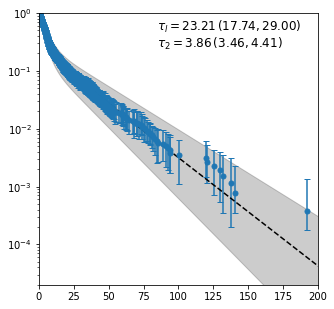

In [26]:
p1,p2,p3,p4 = params_all
curvey = func2(x_all,p1,p2,p3,p4)
p1,p2,p3,p4 = params_cil
curvey_cil = func2(x_all,p1,p2,p3,p4)
p1,p2,p3,p4 = params_ciu
curvey_ciu = func2(x_all,p1,p2,p3,p4)

plt.figure(figsize=(5,5))
plt.errorbar(x_all,y_errorbars[:,0],yerr = [y_errorbars[:,0]-y_errorbars[:,1],y_errorbars[:,2]-y_errorbars[:,0]],fmt='o',ms=5,capsize=3)
plt.plot(x_all,curvey,c='k',ls='--')
plt.fill_between(x_all,curvey_cil,curvey_ciu,color='k',alpha=.2)
plt.ylim(2e-5,1)
plt.yscale('log')
plt.xlim(0,200)
plt.text(85,.5,r'$\tau_l = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[0],tscales_cil[0],tscales_ciu[0]),fontsize=12)
plt.text(85,.25,r'$\tau_2 = {:.2f}\,({:.2f},{:.2f})$'.format(tscales_all[1],tscales_cil[1],tscales_ciu[1]),fontsize=12)
# plt.savefig('dwell_times_biexp_worm_all_worms_2_states_Pierce-Shimomura_{}_{}_delay_{}_with_errorbars.pdf'.format(t0,tf,delay))
plt.show()

In [28]:
rate = (1/tscales_all).sum()

In [30]:
# relaxation time scales implied by the mean dwell times
1/rate,1/rates_cil,1/rates_ciu

(3.3127066987810947, array([3.71595509]), array([2.98994986]))